In [2]:
#from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import os
import shutil
import wfdb
import biosignalsnotebooks as bsnb
plt.style.use('seaborn')

In [3]:
#Read the signal sample - Hosted at Physionet (Needs internet conection)
record = wfdb.rdrecord('100', pn_dir='mitdb/1.0.0') 

In [4]:
#Show record's information
display(record.__dict__)

{'adc_gain': [200.0, 200.0],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'base_counter': None,
 'base_date': None,
 'base_time': None,
 'baseline': [1024, 1024],
 'block_size': [0, 0],
 'byte_offset': [None, None],
 'checksum': [-22131, 20052],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'counter_freq': None,
 'd_signal': None,
 'e_d_signal': None,
 'e_p_signal': None,
 'file_name': ['100.dat', '100.dat'],
 'fmt': ['212', '212'],
 'fs': 360,
 'init_value': [995, 1011],
 'n_sig': 2,
 'p_signal': array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 'record_name': '100',
 'samps_per_frame': [1, 1],
 'sig_len': 650000,
 'sig_name': ['MLII', 'V5'],
 'skew': [None, None],
 'units': ['mV', 'mV']}

In [100]:
#Load of data
data, header = bsnb.load_signal("ecg_4000_Hz", get_header=True)

In [101]:
channel = list(data.keys())[0]

In [102]:
#Sampling rate.
Fs = header["sampling rate"]

# Signal Samples.
ECG_raw = data[channel]

In [103]:
time = bsnb.generate_time(ECG_raw)

In [105]:
bsnb.plot_ecg_pan_tompkins_steps(time, ECG_raw, filtered_signal, Fs, titles=["Original Signal", "Post Filtering Signal"])

<IPython.core.display.Javascript object>


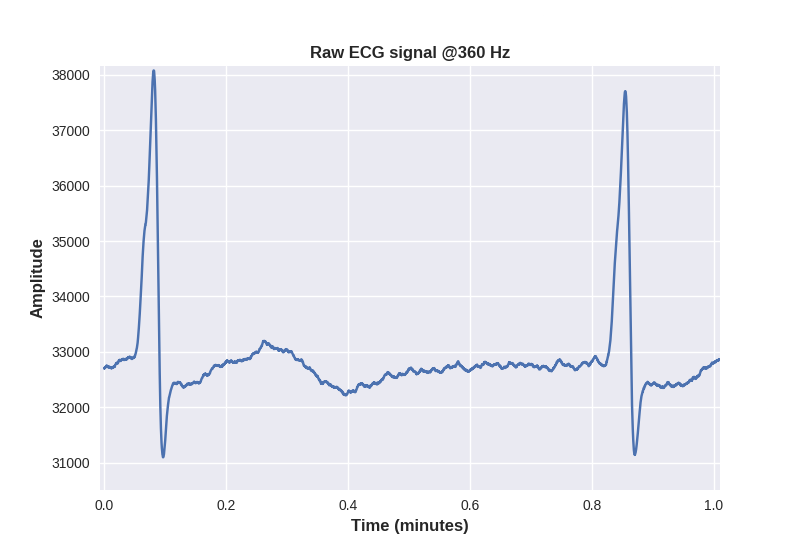

In [107]:
%matplotlib notebook
#Read the ECG signal from the record (1-lead)
#ECG_raw = record.p_signal[:,0]
#Get the sampling frequency
#Fs = int(record.fs)
#Calculates the x=axis
axs = np.linspace(0, len(ECG_raw)/Fs, len(ECG_raw), endpoint=True)
# Plot signal
plt.plot(axs,ECG_raw)
plt.xlabel("Time (minutes)", fontsize = 'large',fontweight = 'bold')
plt.ylabel("Amplitude", fontsize = 'large',fontweight = 'bold')
plt.title("Raw ECG signal @360 Hz", fontsize = 'large',fontweight = 'bold')
plt.show()

## 5 - Simplification of ECG signal (isolation of abrupt transitions)
### 5.1 - Step 1 of Pan-Tompkins Algorithm - ECG Filtering (Bandpass between 5 and 15 Hz) 

In [104]:
# Step 1 of Pan-Tompkins Algorithm
filtered_signal = bsnb.detect._ecg_band_pass_filter(ECG_raw, Fs)

<IPython.core.display.Javascript object>


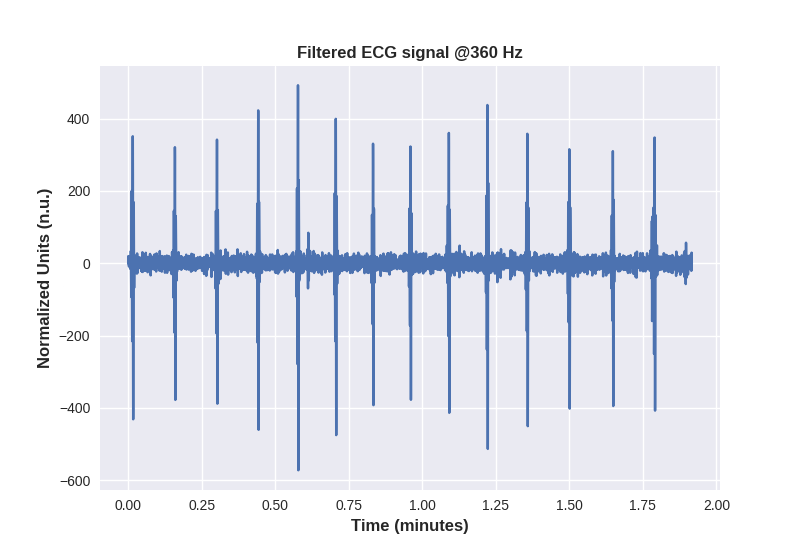

In [83]:
%matplotlib notebook
#Calculates the x=axis
axs = np.linspace(0, len(filtered_signal)/Fs, len(filtered_signal), endpoint=True)
# Plot signal
plt.plot(axs/60,filtered_signal)
plt.xlabel("Time (minutes)", fontsize = 'large',fontweight = 'bold')
plt.ylabel("Normalized Units (n.u.)", fontsize = 'large',fontweight = 'bold')
plt.title("Filtered ECG signal @360 Hz", fontsize = 'large',fontweight = 'bold')
plt.show()

### 5.2 - Step 2 of Pan-Tompkins Algorithm - ECG Differentiation 

In [108]:
# Step 2 of Pan-Tompkins Algorithm
differentiated_signal = np.diff(filtered_signal)

In [110]:
bsnb.plot_ecg_pan_tompkins_steps(time, filtered_signal, differentiated_signal, Fs, titles=["Post Filtering Signal", "Post Differentiation Signal"])

<IPython.core.display.Javascript object>


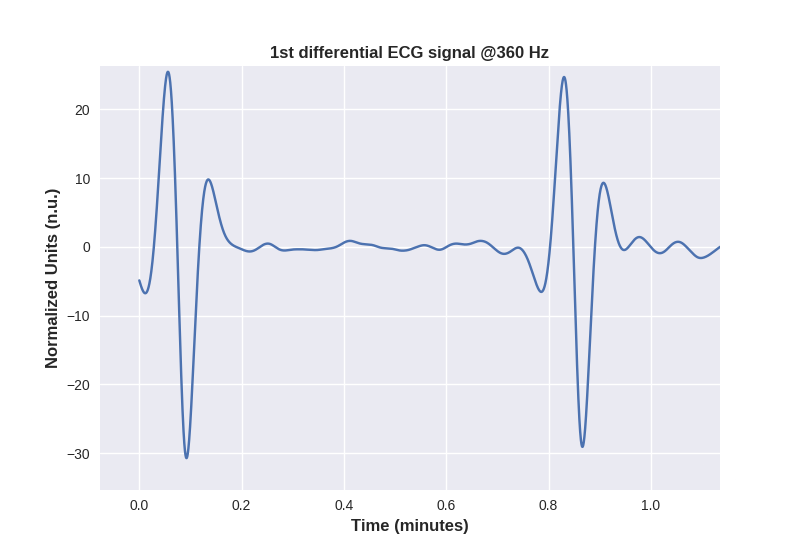

In [111]:
%matplotlib notebook
#Calculates the x=axis
axs = np.linspace(0, len(differentiated_signal)/Fs, len(differentiated_signal), endpoint=True)
# Plot signal
plt.plot(axs,differentiated_signal)
plt.xlabel("Time (minutes)", fontsize = 'large',fontweight = 'bold')
plt.ylabel("Normalized Units (n.u.)", fontsize = 'large',fontweight = 'bold')
plt.title("1st differential ECG signal @360 Hz", fontsize = 'large',fontweight = 'bold')
plt.show()

## 5.3 - Step 3 of Pan-Tompkins Algorithm - ECG Rectification 

In [112]:
# Step 3 of Pan-Tompkins Algorithm
squared_signal = differentiated_signal * differentiated_signal

In [113]:
bsnb.plot_ecg_pan_tompkins_steps(time, filtered_signal, squared_signal, Fs, titles=["Post Differentiation Signal", "Post Rectification Signal"])

<IPython.core.display.Javascript object>


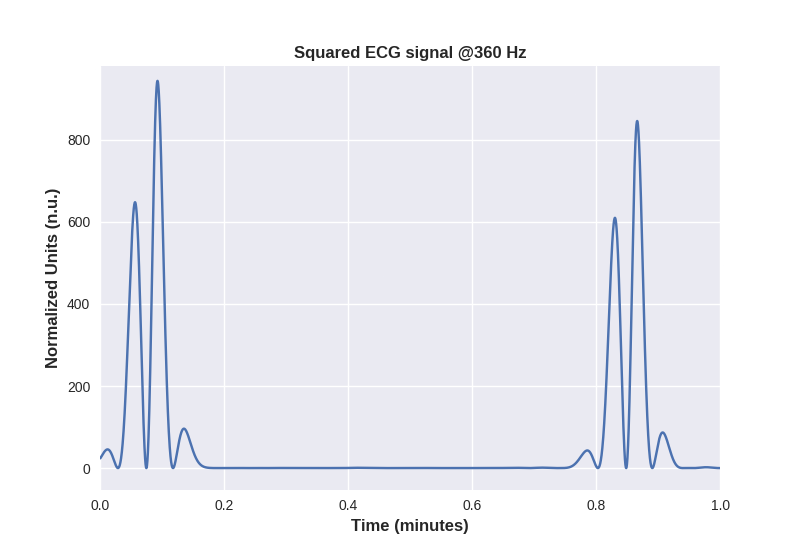

In [114]:
%matplotlib notebook
#Calculates the x=axis
axs = np.linspace(0, len(squared_signal)/Fs, len(squared_signal), endpoint=True)
# Plot signal
plt.plot(axs,squared_signal)
plt.xlabel("Time (minutes)", fontsize = 'large',fontweight = 'bold')
plt.ylabel("Normalized Units (n.u.)", fontsize = 'large',fontweight = 'bold')
plt.title("Squared ECG signal @360 Hz", fontsize = 'large',fontweight = 'bold')
plt.show()

## 5.4 - Step 4 of Pan-Tompkins Algorithm - ECG Integration ( Moving window integration )
### 5.4.1 - Definition of the samples number inside the moving average window 

In [115]:
nbr_sampls_int_wind = int(0.080 * Fs)

### 5.4.2 - Initialisation of the variable that will contain the integrated signal samples


In [116]:
integrated_signal = np.zeros_like(squared_signal)

### 5.4.3 - Determination of a cumulative version of "squared_signal"
#### In the cumulative version of the signal under analysis, his sample value i will be sum of all values included between entry 0 and entry i of the studied signal (in our case "squared_signals"). 

In [117]:
cumulative_sum = squared_signal.cumsum()

### 5.4.4 - Estimation of the area/integral below the curve that defines the "squared_signal"
#### Implicitly, with the current procedure, "squared_signal" is divided into multiple rectangles with fixed width (equal 1 sample) and height determined by the sample value under analysis . 

In [118]:
integrated_signal[nbr_sampls_int_wind:] = (cumulative_sum[nbr_sampls_int_wind:] - 
                                           cumulative_sum[:-nbr_sampls_int_wind]) / nbr_sampls_int_wind
integrated_signal[:nbr_sampls_int_wind] = cumulative_sum[:nbr_sampls_int_wind] / np.arange(1, nbr_sampls_int_wind + 1)

In [119]:
bsnb.plot_ecg_pan_tompkins_steps(time, squared_signal, integrated_signal, Fs, titles=["Post Rectification Signal", "Post Integration Signal"])

<IPython.core.display.Javascript object>


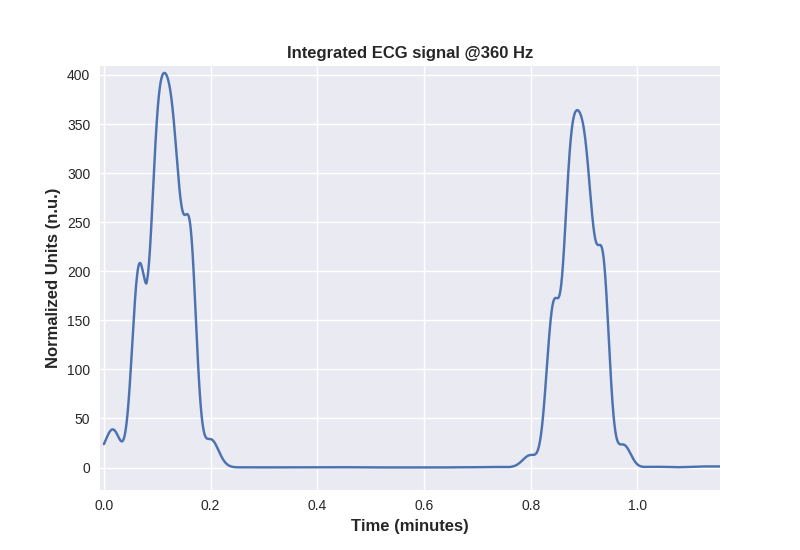

In [120]:
%matplotlib notebook
#Calculates the x=axis
axs = np.linspace(0, len(integrated_signal)/Fs, len(integrated_signal), endpoint=True)
# Plot signal
plt.plot(axs,integrated_signal)
plt.xlabel("Time (minutes)", fontsize = 'large',fontweight = 'bold')
plt.ylabel("Normalized Units (n.u.)", fontsize = 'large',fontweight = 'bold')
plt.title("Integrated ECG signal @360 Hz", fontsize = 'large',fontweight = 'bold')
plt.show()

## 6 - Application of the ECG simplified version to a sequence of peak identification steps
### This task is achieved by using a threshold system, with this threshold being dynamically adjusted along the acquisition, like originally proposed by Pan and Tompkins 

### 6.1 - Initialisation of the R peak detection algorithm


In [121]:
rr_buffer, signal_peak_1, noise_peak_1, threshold = bsnb.detect._buffer_ini(integrated_signal, Fs)

### 6.2 - Detection of possible and probable R peaks
#### Each sample i of our signal is a possible peak if his value is greater than the ones at sample i−1 and i+1. On the other hand, a probable peak is a possible peak that meets some criteria defined by Pan and Tompkins at their original article and synthesised inside _detect_peaks function of biosignalsnotebooks Python package. 

In [122]:
probable_peaks, possible_peaks= bsnb.detect._detects_peaks(integrated_signal, Fs)

#### Entry "0" of the returned result contains the list of probable peaks, while entry "1" refers to the possible_peaks.


### 6.3 - Identification of definitive R peaks
#### Taken into consideration the list of previously detected probable peaks, a set of additional criteria were defined by Pan and Tompkins, in order to exclude peaks from the list of probable peaks. 

In [123]:
definitive_peaks = bsnb.detect._checkup(probable_peaks, integrated_signal, Fs, rr_buffer, signal_peak_1, noise_peak_1, threshold)

# Conversion to integer type.
definitive_peaks = np.array(list(map(int, definitive_peaks)))

### 6.5 - Correcting step
#### Due to the multiple pre-processing stages there is a small lag in the determined peak positions, which needs to be corrected ! 

In [124]:
map_integers = definitive_peaks - 40 * (Fs / 1000)
definitive_peaks_reph = np.array(list(map(int, map_integers)))

## 7 - Evolution of the detected peaks (from possible to definitive R peaks)

In [126]:
bsnb.plot_ecg_pan_tompkins_peaks(time, ECG_raw, integrated_signal, Fs, possible_peaks, probable_peaks, definitive_peaks)

<IPython.core.display.Javascript object>


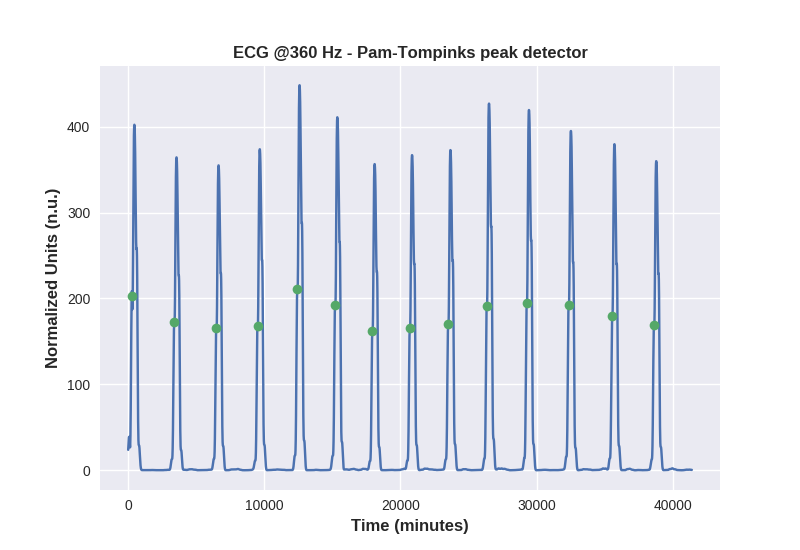

In [127]:
%matplotlib notebook
#Calculates the x=axis
axs = np.linspace(0, len(integrated_signal), len(integrated_signal), endpoint=True)
#axs = axs/60
# Plot signal
plt.plot(axs, integrated_signal, "-", axs[definitive_peaks_reph], integrated_signal[definitive_peaks_reph], "o")
                    
plt.xlabel("Time (minutes)", fontsize = 'large',fontweight = 'bold')
plt.ylabel("Normalized Units (n.u.)", fontsize = 'large',fontweight = 'bold')
plt.title("ECG @360 Hz - Pam-Tompinks peak detector", fontsize = 'large',fontweight = 'bold')
plt.show()

In [25]:
definitive_peaks_reph

array([    69,    362,    655, ..., 649224, 649476, 649726])

## This procedure can be automatically done by detect_r_peaks function in detect module of opensignalstools package


In [98]:
detected_peaks = bsnb.detect_r_peaks(ECG_raw, Fs, time_units=True, plot_result=True)

In [ ]:
# Extract RR interval from peaks

In [56]:
peaks = definitive_peaks_reph.copy()
rr_list = (np.diff(r_peaks) / Fs) * 1000.0

<IPython.core.display.Javascript object>


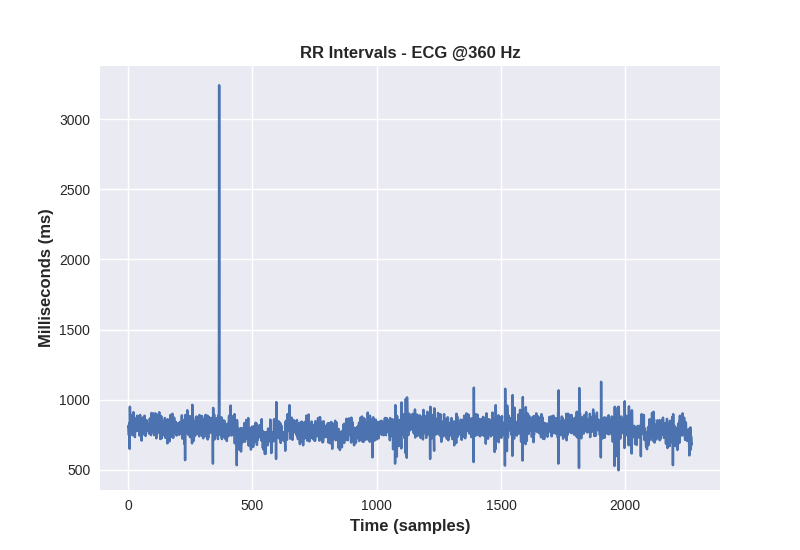

In [57]:
%matplotlib notebook
plt.plot(rr_list)                    
plt.xlabel("Time (samples)", fontsize = 'large',fontweight = 'bold')
plt.ylabel("Milliseconds (ms)", fontsize = 'large',fontweight = 'bold')
plt.title("RR Intervals - ECG @360 Hz",fontsize = 'large',fontweight = 'bold')
plt.show()

In [34]:
!pip install  py-ecg-detectors

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
     |################################| 554 kB 23.8 MB/s eta 0:00:01
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43805 sha256=def295a6ca17cc77277dbb7671395097204a2f3d39e686a59641f927660cd11e
  Stored in directory: /data/home/vastmindz_superman/.cache/pip/wheels/1d/34/8c/b45a0e3889e78a2a5e9a3c34220fc04bf2650e8dd1666fdd6e
Successfully built gatspy


In [46]:
from ecgdetectors import Detectors
detectors = Detectors(360)

In [52]:
ECG_raw = record.p_signal[:,1]

In [53]:
r_peaks = detectors.pan_tompkins_detector(ECG_raw)

In [42]:
r_peaks = detectors.hamilton_detector(ECG_raw)

In [54]:
r_peaks

[109,
 399,
 692,
 974,
 1243,
 1543,
 1838,
 2072,
 2414,
 2705,
 3010,
 3295,
 3570,
 3891,
 4183,
 4477,
 4776,
 5090,
 5359,
 5645,
 5931,
 6227,
 6555,
 6835,
 7118,
 7404,
 7682,
 7981,
 8245,
 8552,
 8864,
 9152,
 9431,
 9723,
 10009,
 10310,
 10604,
 10923,
 11203,
 11492,
 11780,
 12065,
 12361,
 12674,
 12962,
 13279,
 13573,
 13841,
 14130,
 14451,
 14739,
 15039,
 15339,
 15619,
 15927,
 16182,
 16464,
 16767,
 17057,
 17371,
 17685,
 17975,
 18254,
 18543,
 18821,
 19092,
 19401,
 19720,
 20001,
 20300,
 20583,
 20850,
 21143,
 21434,
 21742,
 22042,
 22332,
 22614,
 22894,
 23192,
 23481,
 23768,
 24065,
 24358,
 24653,
 24926,
 25210,
 25496,
 25808,
 26101,
 26399,
 26698,
 26980,
 27249,
 27535,
 27861,
 28162,
 28443,
 28739,
 29025,
 29321,
 29608,
 29884,
 30209,
 30515,
 30807,
 31076,
 31377,
 31648,
 31955,
 32235,
 32560,
 32865,
 33154,
 33415,
 33704,
 33979,
 34301,
 34574,
 34883,
 35167,
 35454,
 35749,
 36029,
 36321,
 36615,
 36943,
 37227,
 37510,
 37811

<IPython.core.display.Javascript object>


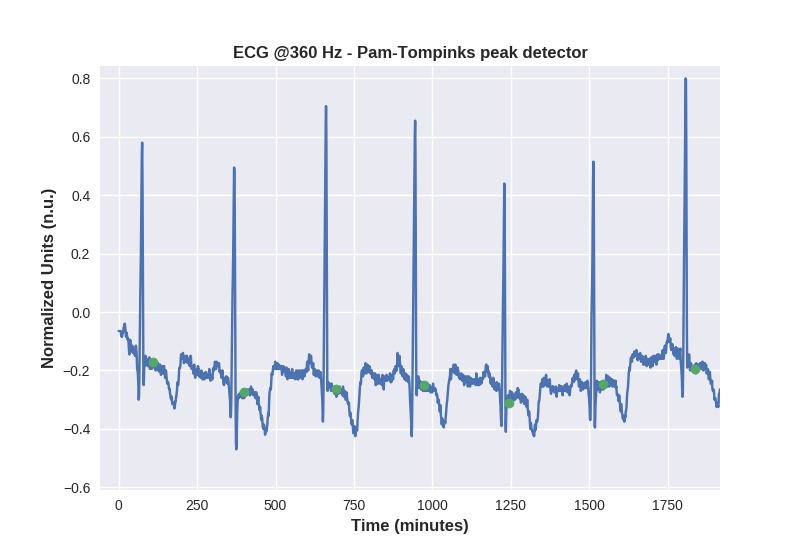

In [55]:
%matplotlib notebook
#Calculates the x=axis
axs = np.linspace(0, len(ECG_raw), len(ECG_raw), endpoint=True)
#axs = axs/60
# Plot signal
plt.plot(axs, ECG_raw, "-", axs[r_peaks], ECG_raw[r_peaks], "o")
                    
plt.xlabel("Time (minutes)", fontsize = 'large',fontweight = 'bold')
plt.ylabel("Normalized Units (n.u.)", fontsize = 'large',fontweight = 'bold')
plt.title("ECG @360 Hz - Pam-Tompinks peak detector", fontsize = 'large',fontweight = 'bold')
plt.show()